In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from gala.coordinates import GD1Koposov10, reflex_correct
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

/Users/mariahjones/Desktop/student_download/episode_functions.py:127: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_1$ [deg]')
/Users/mariahjones/Desktop/student_download/episode_functions.py:128: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\phi_2$ [deg]')


In [2]:
!pwd

/Users/mariahjones/desktop/student_download


In [3]:
!ls

Cython-3.0.7-py2.py3-none-any.whl
PyYAML-6.0.1-cp311-cp311-macosx_11_0_arm64.whl
Untitled.ipynb
__pycache__
astropy-6.0.0-cp311-cp311-macosx_11_0_arm64.whl
astropy_iers_data-0.2024.1.1.0.33.39-py3-none-any.whl
az-paper-twocol.mplstyle
backup-data
data_wkshp1.ipynb
environment.yml
episode_functions.py
gala-1.8.1-cp311-cp311-macosx_11_0_arm64.whl
gd1_data.hdf
gd1_isochrone.hdf5
gd1_results.fits
gdi_data.hdf
numpy-1.26.3-cp311-cp311-macosx_11_0_arm64.whl
packaging-23.2-py3-none-any.whl
pyerfa-2.0.1.1-cp39-abi3-macosx_11_0_arm64.whl
scipy-1.11.4-cp311-cp311-macosx_12_0_arm64.whl
test_setup.ipynb


In [4]:
filename = 'gd1_data.hdf'
centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

In [6]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)
gd1_frame = GD1Koposov10()

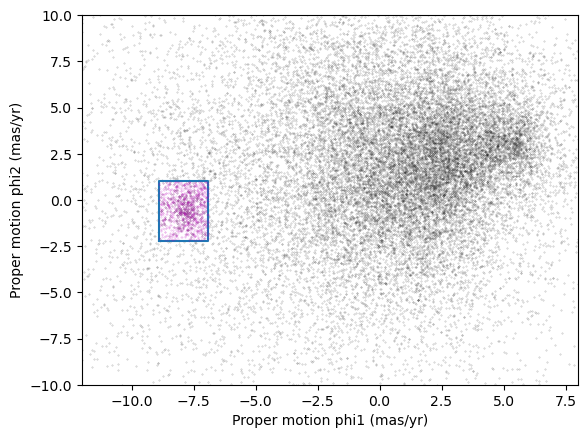

In [7]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect)
x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'mo', markersize = 0.3, alpha = 0.3)

In [8]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1049 entries, 7 to 140239
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  1049 non-null   int64  
 1   ra         1049 non-null   float64
 2   dec        1049 non-null   float64
 3   pmra       1049 non-null   float64
 4   pmdec      1049 non-null   float64
 5   parallax   1049 non-null   float64
 6   phi1       1049 non-null   float64
 7   phi2       1049 non-null   float64
 8   pm_phi1    1049 non-null   float64
 9   pm_phi2    1049 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 90.1 KB


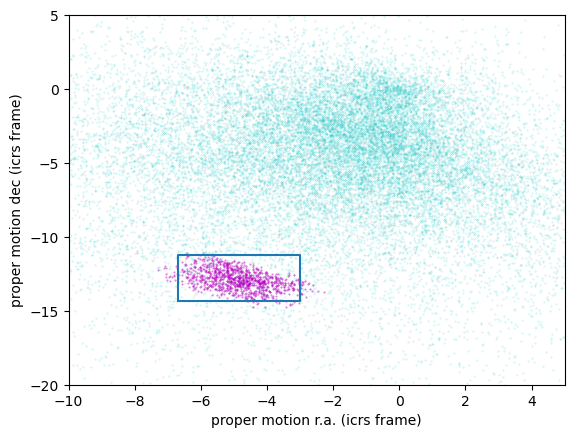

In [48]:
x = centerline_df['pmra']
y = centerline_df['pmdec']
plt.plot(x, y, 'co', markersize = 0.3, alpha = 0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'mo', markersize = 0.5, alpha = 0.5)

plt.xlabel('proper motion r.a. (icrs frame)')
plt.ylabel('proper motion dec (icrs frame)')
plt.xlim((-10, 5))
plt.ylim((-20, 5))

#box
pmra_min = -6.7
pmra_max = -3
pmdec_min = -14.31
pmdec_max = -11.2

pmra_rect, pmdec_rect = make_rectangle(pmra_min, pmra_max, pmdec_min, pmdec_max)
plt.plot(pmra_rect, pmdec_rect)

In [22]:
candidate_coord_query_base = '''
SELECT {columns}
FROM gaiadr2.gaia.source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec), POLYGON({sky_point_list}))
'''

In [23]:
phi1_min = -70 * u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = +5 * u.degree

In [24]:
phi1_rect, phi2_rect = make_rectangle(phi1_min, phi1_max, phi2_min, phi2_max)

In [25]:
corners = SkyCoord(phi1 = phi1_rect, phi2 = phi2_rect, frame = gd1_frame)

In [26]:
corners_icrs = corners.transform_to('icrs')

In [27]:
sky_point_list = skycoord_to_string(corners_icrs)
print(sky_point_list)

135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862


In [36]:
columns = 'source_id, ra, dec, pmra, pmdec'

In [37]:
candidate_coord_query = candidate_coord_query_base.format(
     columns = columns,
     sky_point_list = sky_point_list )
print(candidate_coord_query)


SELECT source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia.source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec), POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



In [45]:
candidate_coord_pm_query_base = '''
SELECT {columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec), POLYGON({sky_point_list}))
    AND pmra BETWEEN {pmra_min} AND {pmra_max}
    AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
'''

In [49]:
candidate_coord_pm_query = candidate_coord_pm_query_base.format(
    columns = columns,
    sky_point_list = sky_point_list,
    pmra_min = pmra_min,
    pmra_max = pmra_max,
    pmdec_min = pmdec_min,
    pmdec_max = pmdec_max
)
print(candidate_coord_pm_query)


SELECT source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec), POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
    AND pmra BETWEEN -6.7 AND -3
    AND pmdec BETWEEN -14.31 AND -11.2



In [50]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)
print(candidate_coord_pm_job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=8409>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1704644407266O
Phase: COMPLETED
Owner: None
Output file: async_20240107102007.vot
Results: None


In [51]:
candidate_gaia_table = candidate_coord_pm_job.get_results()
len(candidate_gaia_table)

8409

In [52]:
d = dict(sky_point_list = sky_point_list,
        pmra_min = pmra_min,
        pmra_max = pmra_max,
        pmdec_min = pmdec_min,
        pmdec_max = pmdec_max)
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -6.7,
 'pmra_max': -3,
 'pmdec_min': -14.31,
 'pmdec_max': -11.2}

In [53]:
point_series = pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                       -6.7
pmra_max                                                         -3
pmdec_min                                                    -14.31
pmdec_max                                                     -11.2
dtype: object

In [54]:
filename = 'gd1_data.hdf'
point_series.to_hdf(filename, 'point_series')

/var/folders/3j/2g_13vvn75j6yhy5nbqvj3bc0000gn/T/ipykernel_19965/1683950938.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  point_series.to_hdf(filename, 'point_series')


Text(0, 0.5, 'dec (degrees icrs)')

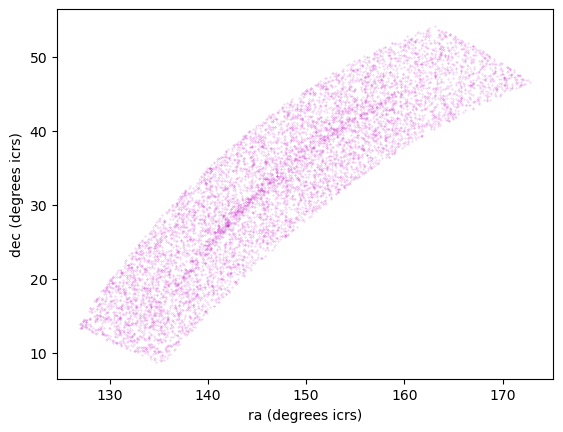

In [55]:
x = candidate_gaia_table['ra']
y = candidate_gaia_table['dec']
plt.plot(x, y, 'mo', markersize = 0.3, alpha = 0.3)
plt.xlabel('ra (degrees icrs)')
plt.ylabel('dec (degrees icrs)')

In [56]:
candidate_gaia_df = make_dataframe(candidate_gaia_table)

In [57]:
candidate_gaia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8409 entries, 0 to 8408
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  8409 non-null   int64  
 1   ra         8409 non-null   float64
 2   dec        8409 non-null   float64
 3   pmra       8409 non-null   float64
 4   pmdec      8409 non-null   float64
 5   phi1       8409 non-null   float64
 6   phi2       8409 non-null   float64
 7   pm_phi1    8409 non-null   float64
 8   pm_phi2    8409 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 591.4 KB


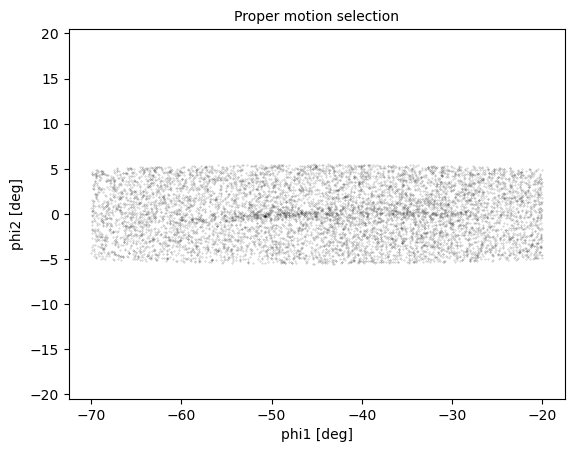

In [61]:
plot_pm_selection(candidate_gaia_df)

In [101]:
ps_best_neighbours_meta = Gaia.load_table('gaiadr2.panstarrs1_best_neighbour')

Retrieving table 'gaiadr2.panstarrs1_best_neighbour'


In [102]:
for column in ps_best_neighbours_meta.columns:
    print(column.name)

source_id
original_ext_source_id
angular_distance
number_of_neighbours
number_of_mates
best_neighbour_multiplicity
gaia_astrometric_params


In [103]:
ps_best_neighbours_query = '''
SELECT
Top 5
source_id, best_neighbour_multiplicity, number_of_mates, original_ext_source_id
FROM gaiadr2.panstarrs1_best_neighbour
'''

In [104]:
ps_best_neighbours_job = Gaia.launch_job(ps_best_neighbour_query)
ps_best_neighbours_results = ps_best_neighbour_job.get_results()
ps_best_neighbours_results

source_id,best_neighbour_multiplicity,number_of_mates,original_ext_source_id
int64,int16,int16,int64
6745938972433480704,1,0,69742925668851205
6030466788955954048,1,0,69742509325691172
6756488099308169600,1,0,69742879438541228
6700154994715046016,1,0,69743055581721207
6757061941303252736,1,0,69742856540241198


In [105]:
ps_valid_meta = Gaia.load_table('gaiadr2.panstarrs1_original_valid')

Retrieving table 'gaiadr2.panstarrs1_original_valid'


In [106]:
print(ps_valid_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_original_valid
Description: The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) is
a system for wide-field astronomical imaging developed and operated by
the Institute for Astronomy at the University of Hawaii. Pan-STARRS1
(PS1) is the first part of Pan-STARRS to be completed and is the basis
for Data Release 1 (DR1). The PS1 survey used a 1.8 meter telescope and
its 1.4 Gigapixel camera to image the sky in five broadband filters (g,
r, i, z, y).

The current table contains a filtered subsample of the 10 723 304 629
entries listed in the original ObjectThin table.
We used only ObjectThin and MeanObject tables to extract
panstarrs1OriginalValid table, this means that objects detected only in
stack images are not included here. The main reason for us to avoid the
use of objects detected in stack images is that their astrometry is not
as good as the mean objects astrometry: “The stack positions (raStack,
decStack) have considera

In [107]:
for column in ps_valid_meta.columns:
    print(column.name)

obj_name
obj_id
ra
dec
ra_error
dec_error
epoch_mean
g_mean_psf_mag
g_mean_psf_mag_error
g_flags
r_mean_psf_mag
r_mean_psf_mag_error
r_flags
i_mean_psf_mag
i_mean_psf_mag_error
i_flags
z_mean_psf_mag
z_mean_psf_mag_error
z_flags
y_mean_psf_mag
y_mean_psf_mag_error
y_flags
n_detections
zone_id
obj_info_flag
quality_flag


In [108]:
ps_valid_query = '''
SELECT
Top 5
obj_id, g_mean_psf_mag, i_mean_psf_mag
FROM gaiadr2.panstarrs1_original_valid
'''

In [109]:
ps_valid_job = Gaia.launch_job(ps_valid_query)
ps_valid_results = ps_valid_job.get_results()
ps_valid_results

obj_id,g_mean_psf_mag,i_mean_psf_mag
,,mag
int64,float64,float64
67130655389101425,--,20.3516006469727
67553305590067819,--,19.779899597168
67551423248967849,--,19.8889007568359
67132026238911331,--,20.9062995910645
67553513677687787,--,21.2831001281738


In [110]:
test_cone_query = '''
SELECT
Top 10
source_id
FROM gaiadr2.gaia_source
WHERE 1 = CONTAINS(POINT(ra,dec), CIRCLE(88.8, 7.4, 0.083333))
'''

In [111]:
test_cone_job = Gaia.launch_job(test_cone_query)
test_cone_results = test_cone_job.get_results()
test_cone_results

source_id
int64
3322773965056065536
3322773758899157120
3322774068134271104
3322773930696320512
3322774377374425728
3322773724537891456
3322773724537891328
3322773930696321792
3322773724537890944


In [112]:
cone_query_base = '''
SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE 1 = CONTAINS(POINT(ra,dec), CIRCLE(88.8, 7.4, 0.083333))
'''

In [113]:
columns = 'source_id, ra, dec, pmra, pmdec'

In [114]:
cone_query = cone_query_base.format(columns = columns)
print(cone_query)


SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE 1 = CONTAINS(POINT(ra,dec), CIRCLE(88.8, 7.4, 0.083333))



In [115]:
cone_job = Gaia.launch_job(cone_query)
cone_results = cone_job.get_results()
cone_results

source_id,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907
3322773758899157120,88.83227057144585,7.325577341429926,--,--
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008


In [160]:
neighbours_query_base = '''
SELECT
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
WHERE 1 = CONTAINS(
    POINT(gaia.ra, gaia.dec), 
    CIRCLE(88.8, 7.4, 0.083333))
'''

In [169]:
column_list_neighbours = [
    'gaia.source_id',
    'gaia.ra',
    'gaia.dec',
    'gaia.pmra',
    'gaia.pmdec',
    'best.best_neighbour_multiplicity',
    'best.number_of_mates'
]

In [170]:
columns = ', '.join(column_list_neighbours)
neighbours_query = neighbours_query_base.format(columns = columns)
print(neighbours_query)


SELECT
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
WHERE 1 = CONTAINS(
    POINT(gaia.ra, gaia.dec), 
    CIRCLE(88.8, 7.4, 0.083333))



In [171]:
neighbours_job = Gaia.launch_job(neighbours_query)

In [172]:
neighbours_results = neighbours_job.get_results()
neighbours_results

source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates
,deg,deg,mas / yr,mas / yr,,
int64,float64,float64,float64,float64,int16,int16
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008,1,0
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333,1,0


In [178]:
join_solution_query_base = '''
SELECT
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid AS ps
    ON best.original_ext_source_id = ps.obj_id
WHERE 1 = CONTAINS(
    POINT(gaia.ra, gaia.dec), 
    CIRCLE(88.8, 7.4, 0.083333))
'''

In [179]:
column_list_ps = [
    'gaia.source_id',
    'gaia.ra',
    'gaia.dec',
    'gaia.pmra',
    'gaia.pmdec',
    'best.best_neighbour_multiplicity',
    'best.number_of_mates',
    'ps.g_mean_psf_mag',
    'ps.i_mean_psf_mag'
]

In [180]:
column_ps = ', '.join(column_list_ps)

In [181]:
join_solution_query = join_solution_query_base.format(columns = column_ps)
print(join_solution_query)


SELECT
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid AS ps
    ON best.original_ext_source_id = ps.obj_id
WHERE 1 = CONTAINS(
    POINT(gaia.ra, gaia.dec), 
    CIRCLE(88.8, 7.4, 0.083333))



In [182]:
join_solution_job = Gaia.launch_job(join_solution_query)
join_solution_results = join_solution_job.get_results()
join_solution_results

source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0,19.9431991577148,17.4221992492676
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0,18.6212005615234,16.6007995605469
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0,--,20.2203998565674
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0,18.0676002502441,16.9762001037598
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0,20.1907005310059,17.8700008392334
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0,22.6308002471924,19.6004009246826
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008,1,0,21.2119998931885,18.3528003692627
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333,1,0,20.8094005584717,18.1343002319336


In [183]:
candidate_coord_pm_query_base = '''
SELECT {columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec), POLYGON({sky_point_list}))
    AND pmra BETWEEN {pmra_min} AND {pmra_max}
    AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
'''

In [184]:
candidate_join_query_base = '''
SELECT
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid AS ps
    ON best.original_ext_source_id = ps.obj_id
WHERE gaia.parallax < 1
    AND gaia.bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec), POLYGON({sky_point_list}))
    AND gaia.pmra BETWEEN {pmra_min} AND {pmra_max}
    AND gaia.pmdec BETWEEN {pmdec_min} AND {pmdec_max}
'''

In [188]:
candidate_join_query = candidate_join_query_base.format(columns = column_ps,
                                                       sky_point_list = sky_point_list,
                                                       pmra_min = pmra_min,
                                                       pmra_max = pmra_max,
                                                       pmdec_min = pmdec_min,
                                                       pmdec_max = pmdec_max)
print(candidate_join_query)


SELECT
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
    ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid AS ps
    ON best.original_ext_source_id = ps.obj_id
WHERE gaia.parallax < 1
    AND gaia.bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec), POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
    AND gaia.pmra BETWEEN -6.7 AND -3
    AND gaia.pmdec BETWEEN -14.31 AND -11.2



In [243]:
candidate_join_job = Gaia.launch_job_async(candidate_join_query)
candidate_table = candidate_join_job.get_results()
candidate_table

INFO: Query finished. [astroquery.utils.tap.core]


source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392,1,0,17.8978004455566,17.5174007415771
635674126383965568,138.8428741026386,19.031798198627634,-3.8970011609340207,-12.702779525389634,1,0,19.2873001098633,17.6781005859375
635614168640132864,139.59219748145836,18.807955539071433,-3.309602916796381,-13.708904908478631,1,0,16.1515998840332,14.6662998199463
635694467349085056,139.06182692172476,19.06744237567232,-3.0674889862265795,-11.4175270465402,1,0,18.6709003448486,17.9841995239258
635598607974369792,139.20920023089508,18.624132868942702,-6.124445176881091,-12.833824027100611,1,0,16.5223999023438,16.1375007629395
635850945892748672,139.86542888472115,20.011312663154804,-3.786655365804428,-14.28415600718206,1,0,16.5174999237061,16.0450000762939
635600532119713664,139.22869949616816,18.685939084485494,-3.9742788217925122,-12.342426623384245,1,0,20.4505996704102,19.5177001953125
635620701286087424,139.6862822364899,18.881113520820737,-3.3558418379356474,-12.925224236202752,1,0,20.4113006591797,19.5032997131348


In [244]:
candidate_df = make_dataframe(candidate_table)

In [245]:
candidate_df.to_hdf(filename, 'candidate_df')

In [194]:
from os.path import getsize 
MB = 1024 * 1024
getsize(filename)/MB

15.203163146972656

In [196]:
candidate_df.describe()

,source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0,1960.000000,1997.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,7.406967e+17,150.132740,34.979769,-4.770718,-12.516718,1.0,0.0,19.460557,18.460836,-40.592503,-0.114916,-7.038125,-1.260627
std,7.160386e+16,11.231213,10.312950,1.076413,0.853234,0.0,0.0,1.842698,1.564946,13.430446,2.759598,1.131522,1.733630
min,5.853682e+17,126.953102,8.827857,-6.698099,-14.307631,1.0,0.0,12.479000,11.519200,-69.712205,-5.361482,-10.631108,-6.134588
25%,6.875052e+17,140.579031,25.916170,-5.684285,-13.172360,1.0,0.0,18.417800,17.642401,-52.363251,-2.324535,-7.820925,-2.603808
50%,7.767920e+17,146.654692,37.318947,-4.720448,-12.416667,1.0,0.0,19.834250,18.906700,-39.951240,-0.141988,-7.088168,-1.132830
75%,8.027508e+17,160.543085,45.076678,-3.832648,-11.779055,1.0,0.0,20.862374,19.643000,-27.372566,1.864948,-6.248493,-0.031534
max,8.359909e+17,172.575405,51.046267,-3.000743,-11.200680,1.0,0.0,22.539101,21.052200,-20.002073,5.437899,-3.989855,3.113953


In [197]:
multiplicity = candidate_df['best_neighbour_multiplicity']
multiplicity.describe()

count    2000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: best_neighbour_multiplicity, dtype: float64

In [198]:
candidate_df.to_csv('gd1_data.csv')

In [200]:
getsize('gd1_data.csv')/MB

0.4085378646850586

In [202]:
read_back_csv = pd.read_csv('gd1_data.csv')
read_back_csv.head()

,Unnamed: 0,source_id,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
0,0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,1,0,17.8978,17.517401,-59.247330,-2.016078,-7.527126,1.748779
1,1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,1,0,19.2873,17.678101,-59.133391,-2.306901,-7.560608,-0.741800
2,2,635614168640132864,139.592197,18.807956,-3.309603,-13.708905,1,0,16.1516,14.666300,-58.938113,-3.024192,-8.062762,-1.869082
3,3,635694467349085056,139.061827,19.067442,-3.067489,-11.417527,1,0,18.6709,17.984200,-58.991595,-2.461925,-6.020001,-0.769486
4,4,635598607974369792,139.209200,18.624133,-6.124445,-12.833824,1,0,16.5224,16.137501,-59.289567,-2.818825,-8.874803,1.012516


Text(0, 0.5, 'magnitude [g]')

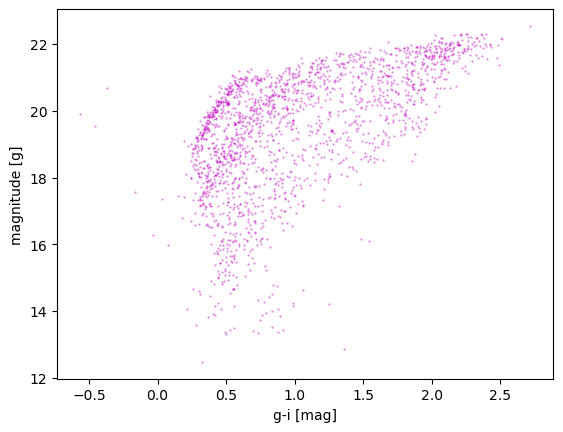

In [206]:
x = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
y = candidate_df['g_mean_psf_mag']
plt.plot(x, y, 'mo', markersize = 0.5, alpha = 0.5)
plt.xlabel('g-i [mag]')
plt.ylabel('magnitude [g]')

(0.0, 1.5)

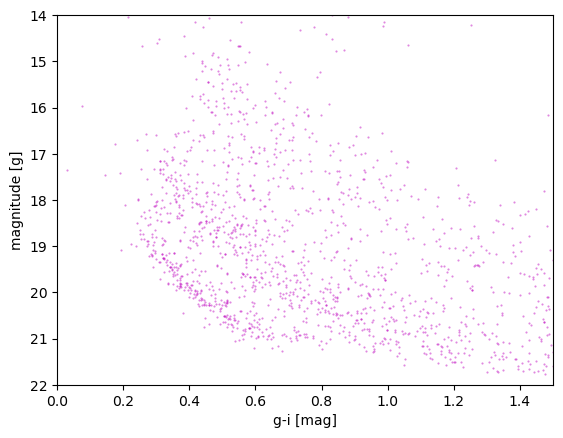

In [207]:
x = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
y = candidate_df['g_mean_psf_mag']
plt.plot(x, y, 'mo', markersize = 0.5, alpha = 0.5)
plt.xlabel('g-i [mag]')
plt.ylabel('magnitude [g]')
plt.ylim((22,14))
plt.xlim((0, 1.5))

In [208]:
def plot_cmd(dataframe):
    '''
    plot a color magnitude diagram

    dataframe: dataframe or table with photometry data
    '''
    x = dataframe['g_mean_psf_mag'] - dataframe['i_mean_psf_mag']
    y = dataframe['g_mean_psf_mag']
   
    plt.plot(x, y, 'mo', markersize = 0.5, alpha = 0.5)
    
    plt.xlabel('g-i [mag]')
    plt.ylabel('magnitude [g]')
    
    plt.ylim((22,14))
    plt.xlim((0, 1.5))

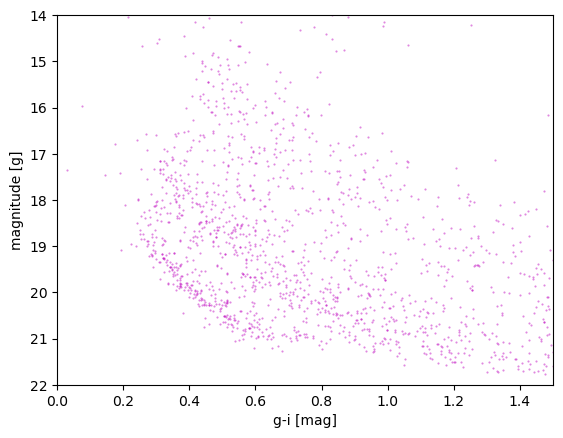

In [209]:
plot_cmd(candidate_df)

In [213]:
filename = 'gd1_isochrone.hdf5'
iso_df = pd.read_hdf(filename, 'iso_df')
iso_df.head()

,mag_g,color_g_i
0,28.294743,2.195021
1,28.189718,2.166076
2,28.051761,2.129312
3,27.916194,2.093721
4,27.780024,2.058585


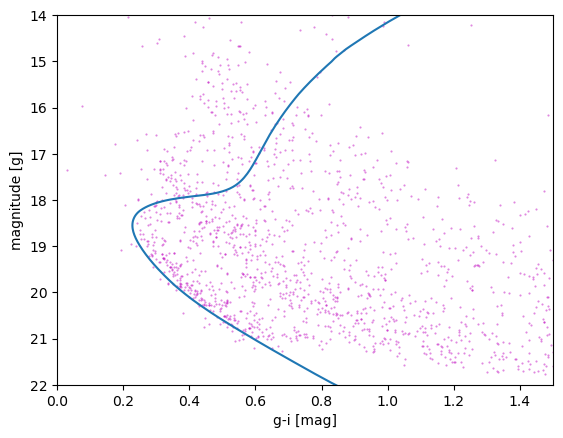

In [214]:
plot_cmd(candidate_df)
plt.plot(iso_df['color_g_i'], iso_df['mag_g'])

In [218]:
g_all = iso_df['mag_g']
g_mask = (g_all > 18) & (g_all < 21.5)
g_mask.sum()

117

In [220]:
iso_masked = iso_df[g_mask]
iso_masked.head()

,mag_g,color_g_i
94,21.411746,0.692171
95,21.322466,0.670238
96,21.233380,0.648449
97,21.144427,0.626924
98,21.054549,0.605461


In [222]:
g = iso_masked['mag_g']
left_color = iso_masked['color_g_i'] - 0.06
right_color = iso_masked['color_g_i'] + 0.12

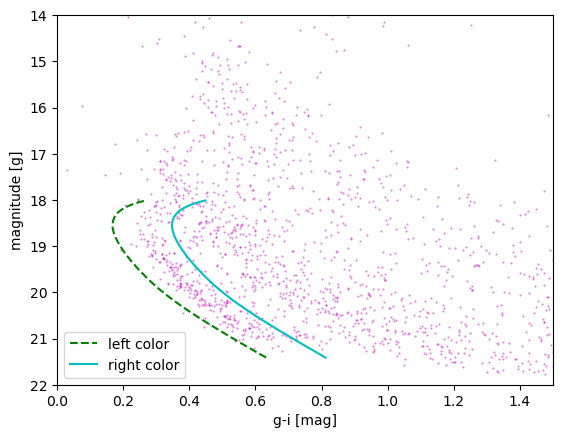

In [227]:
plot_cmd(candidate_df)
plt.plot(left_color, g, 'g--', label = 'left color')
plt.plot(right_color, g, 'c-',label = 'right color')
plt.legend()

In [228]:
reverse_right_color = right_color[::-1]

In [229]:
import numpy as np

In [230]:
color_loop = np.append(left_color, reverse_right_color)
color_loop.shape

(234,)

In [231]:
mag_loop = np.append(g, g[::-1])

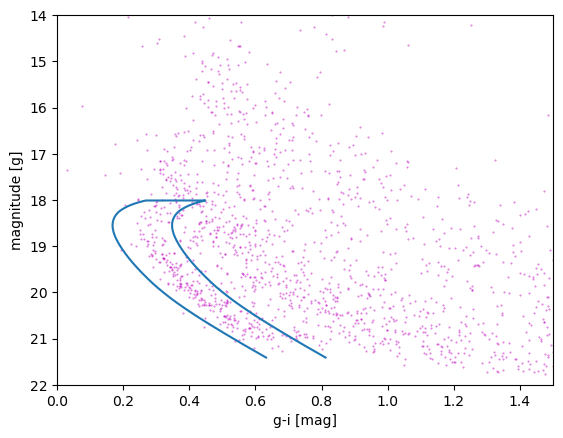

In [232]:
plot_cmd(candidate_df)
plt.plot(color_loop, mag_loop)

In [233]:
loop_df = pd.DataFrame()
loop_df['color_loop'] = color_loop
loop_df['mag_loop'] = mag_loop
loop_df.head()

,color_loop,mag_loop
0,0.632171,21.411746
1,0.610238,21.322466
2,0.588449,21.233380
3,0.566924,21.144427
4,0.545461,21.054549


In [235]:
from matplotlib.patches import Polygon

polygon = Polygon(loop_df)
polygon

In [236]:
test_points = [[0.5, 17], [5, 20], [0.7, 9], [2, 7], [0, 22]]
test_inside = polygon.contains_points(test_points)
test_inside

array([False, False, False, False, False])

In [237]:
filename = 'gd1_data.hdf'
loop_df.to_hdf(filename, 'loop_df')

In [246]:
cmd_df = pd.DataFrame()
cmd_df['color'] = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
cmd_df['mag'] = candidate_df['g_mean_psf_mag']
cmd_df.head()

,color,mag
0,0.380400,17.8978
1,1.609200,19.2873
2,1.485300,16.1516
3,0.686701,18.6709
4,0.384899,16.5224


In [247]:
len(candidate_df
   )

4300

In [248]:
inside_mask = polygon.contains_points(cmd_df)
inside_mask

array([False, False, False, ..., False, False, False])

In [249]:
inside_mask.sum()

486

In [250]:
len(cmd_df)

4300

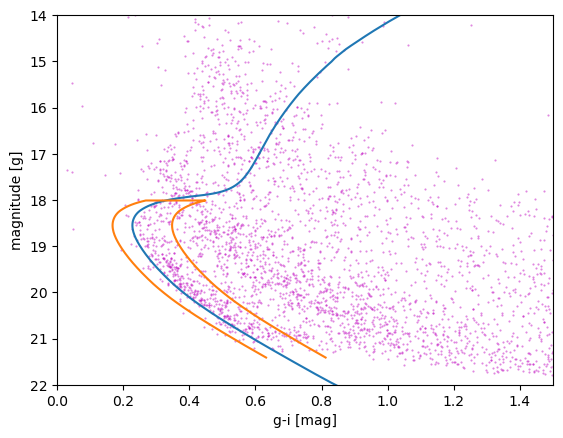

In [252]:
plot_cmd(candidate_df)
plt.plot(iso_df['color_g_i'], iso_df['mag_g'])
plt.plot(color_loop, mag_loop)

winner_df = candidate_df[inside_mask]
x = winner_df['g_mean_psf_mag'] - winner_df[['i_mean_psf_mag']]
y = winner_df[['i_mean_psf_mag']]

plt.plot(x, y, 'm--', markersize = 0.5, alpha = 0.5)
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/3j/2g_13vvn75j6yhy5nbqvj3bc0000gn/T/ipykernel_19965/1732014377.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_1$ (deg)')
/var/folders/3j/2g_13vvn75j6yhy5nbqvj3bc0000gn/T/ipykernel_19965/1732014377.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\phi_2$ (deg)')


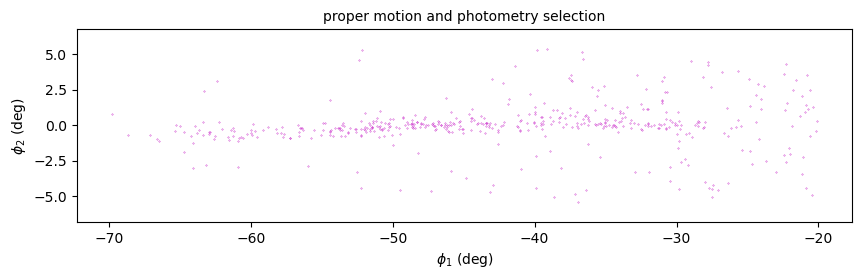

In [257]:
fig = plt.figure(figsize = (10, 2.5))

x = winner_df['phi1']
y = winner_df['phi2']

plt.plot(x, y, 'm.', markersize = 0.5, alpha = 1)

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')

plt.title('proper motion and photometry selection', fontsize = 'medium')
plt.axis('equal')
#plt.legend()
plt.show()

In [258]:
winner_df.to_hdf(filename, 'winner_df')

Text(-35, 5.5, 'Spur')

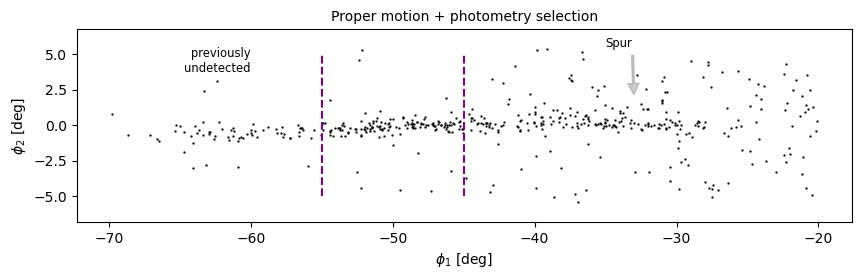

In [267]:
fig = plt.figure(figsize = (10, 2.5))
plot_cmd_selection(winner_df)

#plt.axvline(-55, ls = '--', c = 'purple', ymin = 0.1, ymax = 0.9)
plt.vlines([-55, -45], ls = '--', 
           color = 'purple', ymin = -5, 
           ymax = 5)

plt.text(-60, 5.5, 'previously\nundetected', 
         ha = 'right', va = 'top', 
         fontsize = 'small')

arrowprops = dict(color = 'gray', shrink = 0.05, 
                  width = 1.5, headwidth = 8,
                 headlength = 8, alpha = 0.4)

plt.annotate('Spur', xy = (-33,2), xytext = (-35, 5.5), 
             arrowprops = arrowprops, fontsize = 'small')

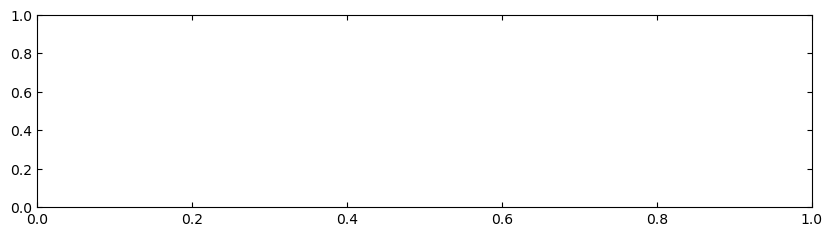

In [268]:
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(1,1,1) # ncol, nrow, plotnum
ax.tick_params(direction='in', top=True, right=True)

In [269]:
import matplotlib as mpl
mpl.matplotlib_fname()

'/Users/mariahjones/anaconda3/envs/AstronomicalData/lib/python3.12/site-packages/matplotlib/mpl-data/matplotlibrc'

In [270]:
plt.rcParams['font.size']

10.0

In [271]:
plt.rcParams['font.size'] = 14

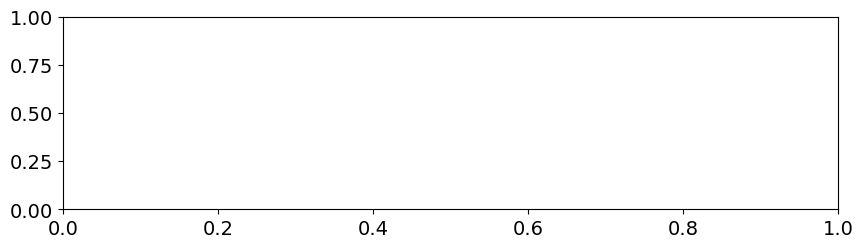

In [272]:
fig = plt.figure(figsize = (10, 2.5))
ax = fig.add_subplot(1, 1, 1) #ncol, nrow, plotnum

In [273]:
mpl.get_configdir()

'/Users/mariahjones/.matplotlib'

In [274]:
plt.style.use('./az-paper-twocol.mplstyle')

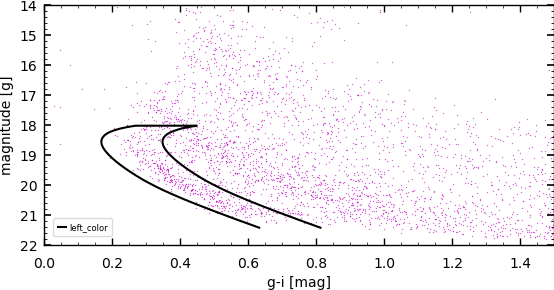

In [277]:
plot_cmd(candidate_df)
plt.plot(loop_df['color_loop'], loop_df['mag_loop'], label = 'left_color')
plt.legend()
plt.show()

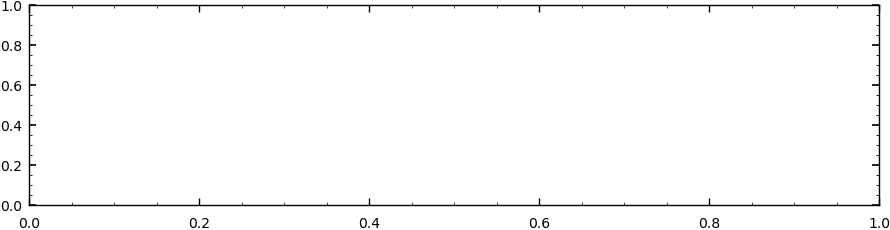

In [278]:
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(1,1,1) # ncol, nrow, plotnum
ax.tick_params(direction='in', top=True, right=True)


In [279]:
import matplotlib as mpl
print(mpl.matplotlib_fname())

plt.rcParams['font.size']

# show all styles that are availble
plt.style.available

# choose a different style
plt.style.use('fivethirtyeight')

# revert back to the default style
plt.style.use('default')

/Users/mariahjones/anaconda3/envs/AstronomicalData/lib/python3.12/site-packages/matplotlib/mpl-data/matplotlibrc


In [280]:

# find where style files etc are stored:
mpl.get_configdir()


#
# now we'll make a plot with multiple sub-panels that are NOT necessarily the same size
#
# return to default style
plt.style.use('default')

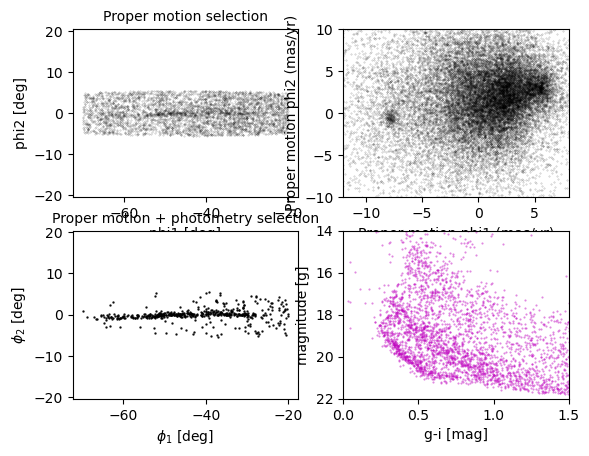

In [281]:
fig = plt.figure()
shape = (2, 2)
ax1 = plt.subplot2grid(shape, (0, 0))
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 1))
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1, 0))
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1, 1))
plot_cmd(candidate_df)

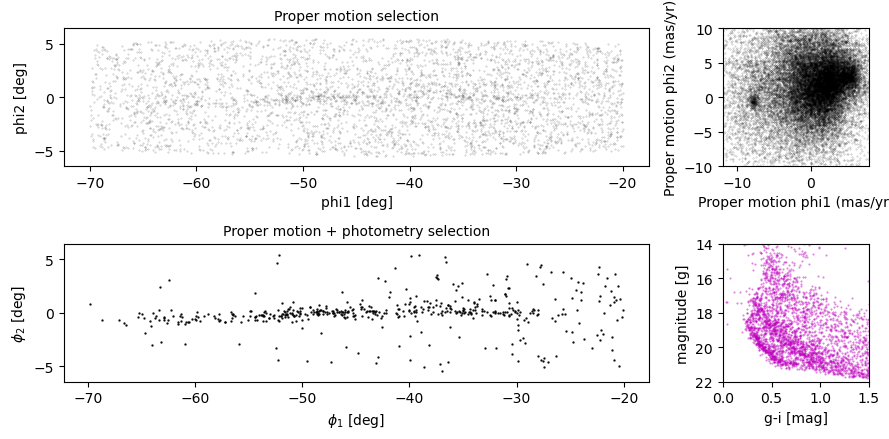

In [282]:
# Now try that again, just changing the shape to make the left plots longer 
plt.style.use('default')
fig = plt.figure(figsize=(9,4.5))
shape = (2,4)
ax1 = plt.subplot2grid(shape, (0, 0), colspan=3)
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 3))
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1, 0), colspan=3)
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1, 3))
plot_cmd(candidate_df)

plt.tight_layout()

In [283]:
vertices = np.transpose([pm1_rect, pm2_rect])

In [284]:
vertices

array([[-8.9, -2.2],
       [-8.9,  1. ],
       [-6.9,  1. ],
       [-6.9, -2.2],
       [-8.9, -2.2]])

In [285]:
poly = Polygon(vertices, closed = True, facecolor = 'purple', alpha = 0.4)

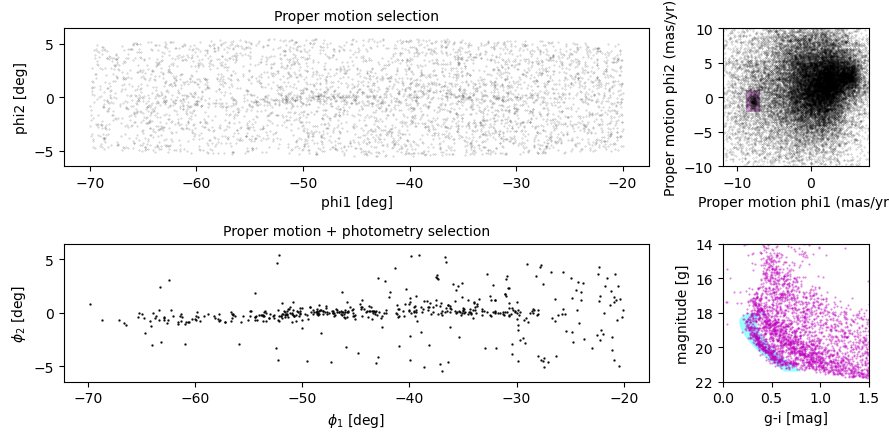

In [287]:
# Now try that again, just changing the shape to make the left plots longer 
plt.style.use('default')
fig = plt.figure(figsize=(9,4.5))
shape = (2,4)
ax1 = plt.subplot2grid(shape, (0, 0), colspan=3)
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 3))
plot_proper_motion(centerline_df)
poly = Polygon(vertices, closed = True, facecolor = 'purple', alpha = 0.4)
ax2.add_patch(poly)

ax3 = plt.subplot2grid(shape, (1, 0), colspan=3)
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1, 3))
plot_cmd(candidate_df)
poly_cmd = Polygon(loop_df, closed = True, facecolor = 'cyan', alpha = 0.4)
ax4.add_patch(poly_cmd)

plt.tight_layout()